In [1]:
from principal_portfolios import utils, principal_portfolios
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator

# Fama French Test Assets

In [ ]:
# File paths for portfolio CSVs and Fama–French test assets CSV
data_to_read_address = [
    "data/Equities/FamaFrench_US_Double_Sorted/25_Portfolios_5x5_SizeBM_monthly.csv",
    "data/Equities/FamaFrench_US_Double_Sorted/25_Portfolios_5x5_SizeOP_monthly.csv",
    "data/Equities/FamaFrench_US_Double_Sorted/25_Portfolios_5x5_SizeINV_monthly.csv"
]
factor_data_address = "data/Equities/FamaFrench_US_Double_Sorted/F-F_Research_Data_5_Factors_2x3.csv"

# Analysis parameters
starting_year_to_filter      = 1963   # Earliest year of data to include (exclusive)
end_year_to_filter           = 2020   # Latest year of data to include (exclusive)
number_of_lookback_periods   = 120    # Lookback window (months) for prediction matrices
number_of_PPs_to_consider    = 3      # Top-n Principal Portfolios to summarize
number_of_PEPs_to_consider   = 3      # Top-n Principal Eigenportfolios to summarize
number_of_PAPs_to_consider   = 3      # Top-n Principal Asymmetric Portfolios to summarize

# ------------------------------------------------------------------------------
# Load and prepare factor return data
# ------------------------------------------------------------------------------
factor_data_monthly = pd.read_csv(factor_data_address)
# Convert YYYYMM to month-end datetime
factor_data_monthly['date'] = utils.convert_date_column_for_monthly_data(factor_data_monthly)

# Container for all results
output_dict = {}

# ------------------------------------------------------------------------------
# Loop over each portfolio dataset, build signals, and run principal portfolios
# ------------------------------------------------------------------------------
for dataset in data_to_read_address:

    # Load monthly portfolio returns
    portfolios_dataset_df = pd.read_csv(dataset)
    # Convert the 'date' column to actual month-end timestamps
    portfolios_dataset_df['date'] = utils.convert_date_column_for_monthly_data(portfolios_dataset_df)
    # Build 1-month momentum signals by shifting returns forward
    signal_df = utils.build_signal_df_for_1month_momentum(portfolios_dataset_df)

    # Use the filename (without path or extension) as the key
    key = dataset.split("FamaFrench_US_Double_Sorted/")[1].split(".csv")[0]
    # Run the end-to-end principal-portfolios pipeline and store the result dict
    output_dict[key] = principal_portfolios.build_PP(
        portfolios_dataset_df,
        signal_df,
        number_of_lookback_periods,
        starting_year_to_filter,
        end_year_to_filter,
        factor_data_monthly=factor_data_monthly
    )

# ------------------------------------------------------------------------------
# Inspecting the results
# ------------------------------------------------------------------------------
# Print top-level dataset keys
print(output_dict.keys())
'''
Each value in output_dict is itself a dict of DataFrames/metrics.
For example, to see the Sharpe ratios for the BM portfolios:
'''
print(output_dict['25_Portfolios_5x5_SizeBM_monthly'].keys())
# To access the Sharpe series directly:
# output_dict['25_Portfolios_5x5_SizeBM_monthly']["sharpe_df"]


dict_keys(['25_Portfolios_5x5_SizeBM_monthly', '25_Portfolios_5x5_SizeOP_monthly', '25_Portfolios_5x5_SizeINV_monthly'])
dict_keys(['realized_returns_df', 'sharpe_df', 'pp_realized_mean_df', 'pp_expected_mean_df', 'pep_realized_mean_df', 'pep_expected_mean_df', 'pap_realized_mean_df', 'pap_expected_mean_df', 'regression_result_return_of_simple_factor', 'regression_result_realized_return_of_first_n_PP', 'regression_result_realized_return_of_first_n_PEP', 'regression_result_realized_return_of_first_n_PAP', 'regression_result_PEP and PAP 1-n'])


Plotting the graphs

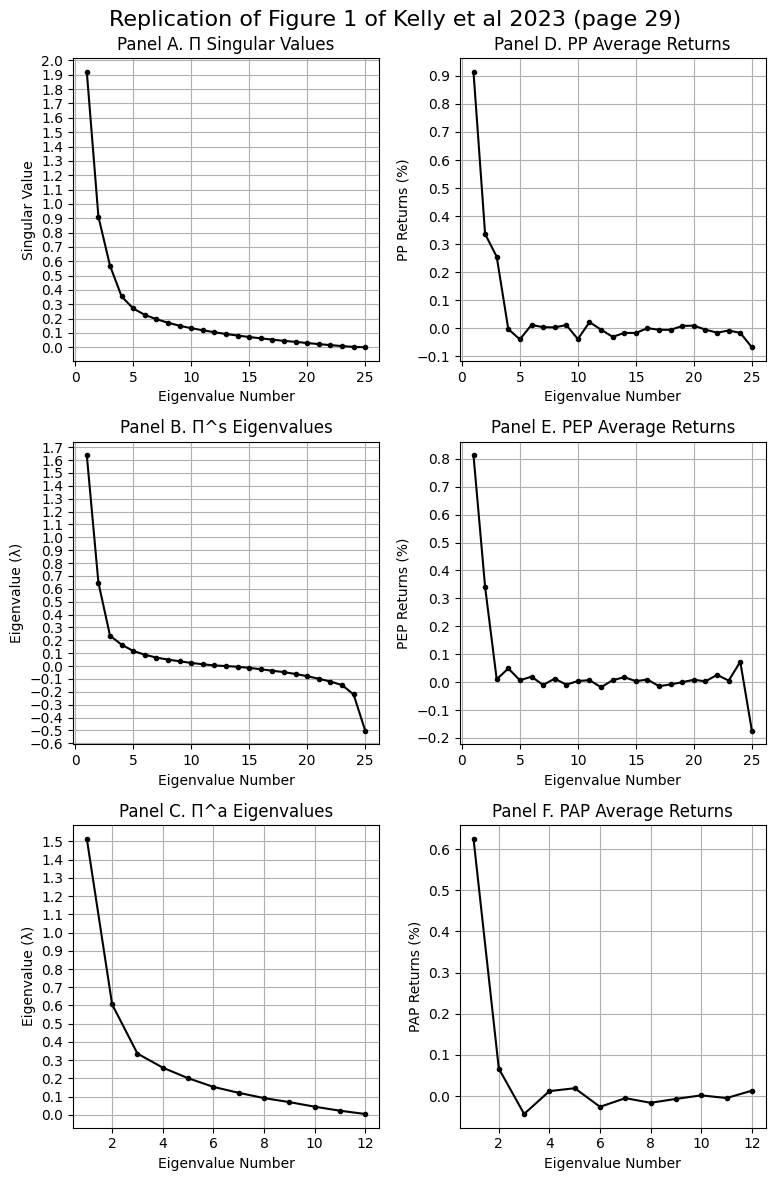

In [4]:
# Derive the total number of portfolios from the DataFrame’s column count
number_of_portfolios = portfolios_dataset_df.shape[1]

# Identify which result set in output_dict to visualize
portfolios_key = "25_Portfolios_5x5_SizeBM_monthly"

# Define the chart title matching Kelly et al. (2023), Figure 1 on page 29
title = 'Replication of Figure 1 of Kelly et al 2023 (page 29)'

# Call the plotting function to produce the 3×2 panel:
# singular values (Π), symmetric eigenvalues (Π^s), antisymmetric eigenvalues (Π^a)
# alongside average realized returns for PP, PEP, and PAP strategies
principal_portfolios.singular_values_vs_realized_returns_graph(
    output_dict,
    portfolios_key,
    number_of_portfolios,
    title
)


Below is the replicated figure.

![alt text](Doc/Replicated_tables_or_figures/Figure_1.jpg)


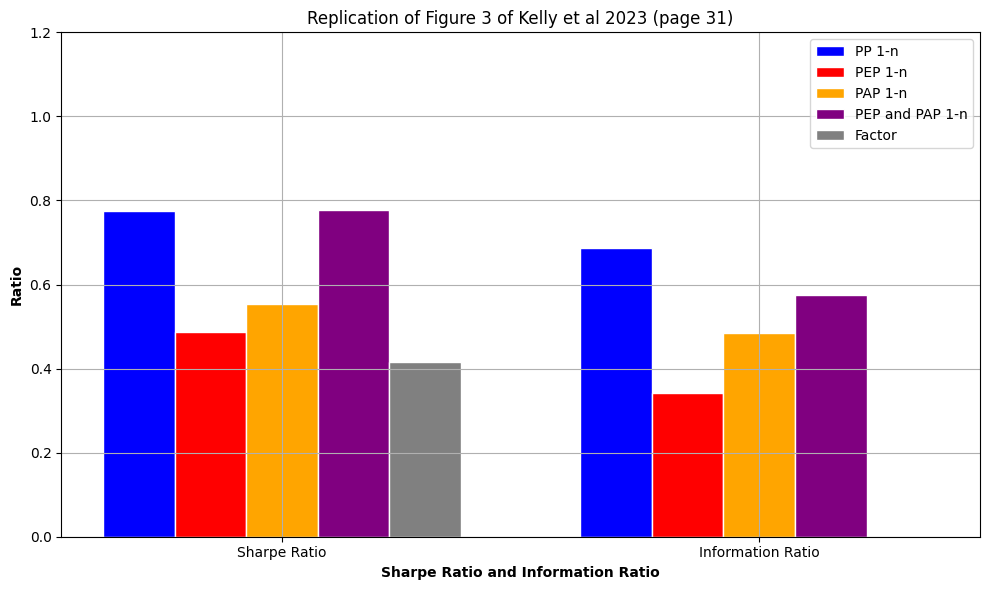

In [9]:
# Define the two ratio categories and the width of each bar
categories = ['Sharpe Ratio', 'Information Ratio']
bar_width = 0.15

# ------------------------------------------------------------
# Retrieve performance metrics for each strategy:
#   [Sharpe Ratio, Information Ratio]
# ------------------------------------------------------------
means_pp = [
    # PP 1-n Sharpe Ratio
    output_dict['25_Portfolios_5x5_SizeBM_monthly']["sharpe_df"]
        .get('realized_return_of_first_n_PP'),
    # PP 1-n Information Ratio (intercept IR from regression output)
    output_dict['25_Portfolios_5x5_SizeBM_monthly'][
        "regression_result_realized_return_of_first_n_PP"
    ][2]
]
means_pep = [
    # PEP 1-n Sharpe Ratio
    output_dict['25_Portfolios_5x5_SizeBM_monthly']["sharpe_df"]
        .get('realized_return_of_first_n_PEP'),
    # PEP 1-n Information Ratio
    output_dict['25_Portfolios_5x5_SizeBM_monthly'][
        "regression_result_realized_return_of_first_n_PEP"
    ][2]
]
means_pap = [
    # PAP 1-n Sharpe Ratio
    output_dict['25_Portfolios_5x5_SizeBM_monthly']["sharpe_df"]
        .get('realized_return_of_first_n_PAP'),
    # PAP 1-n Information Ratio
    output_dict['25_Portfolios_5x5_SizeBM_monthly'][
        "regression_result_realized_return_of_first_n_PAP"
    ][2]
]
means_pep_pap = [
    # Combined PEP & PAP Sharpe Ratio
    output_dict['25_Portfolios_5x5_SizeBM_monthly']["sharpe_df"]
        .get('PEP and PAP 1-n'),
    # Combined PEP & PAP Information Ratio
    output_dict['25_Portfolios_5x5_SizeBM_monthly'][
        "regression_result_PEP and PAP 1-n"
    ][2]
]
means_factor = [
    # Simple factor Sharpe Ratio
    output_dict['25_Portfolios_5x5_SizeBM_monthly']["sharpe_df"]
        .get('return_of_simple_factor'),
    # No Information Ratio for the standalone factor (set to zero)
    0
]

# ------------------------------------------------------------
# Calculate bar positions for each strategy group along the x-axis
# ------------------------------------------------------------
r1 = np.arange(len(categories))                # Positions for PP
r2 = [x + bar_width for x in r1]               # Positions for PEP
r3 = [x + bar_width for x in r2]               # Positions for PAP
r4 = [x + bar_width for x in r3]               # Positions for PEP & PAP combined
r5 = [x + bar_width for x in r4]               # Positions for the simple factor

# ------------------------------------------------------------
# Build the grouped bar chart
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))        # Create figure and axes

# Plot each strategy’s bars with distinct colors and labels
ax.bar(r1, means_pp,     color='blue',   width=bar_width, edgecolor='white', label='PP 1-n')
ax.bar(r2, means_pep,    color='red',    width=bar_width, edgecolor='white', label='PEP 1-n')
ax.bar(r3, means_pap,    color='orange', width=bar_width, edgecolor='white', label='PAP 1-n')
ax.bar(r4, means_pep_pap,color='purple', width=bar_width, edgecolor='white', label='PEP and PAP 1-n')
ax.bar(r5, means_factor, color='gray',   width=bar_width, edgecolor='white', label='Factor')

# ------------------------------------------------------------
# Customize axes, ticks, labels, and title
# ------------------------------------------------------------
ax.set_ylim([0, 1.2])  # Fix y-axis range for readability
ax.set_xlabel('Sharpe Ratio and Information Ratio', fontweight='bold')
ax.set_ylabel('Ratio', fontweight='bold')
ax.set_title('Replication of Figure 3 of Kelly et al 2023 (page 31)')

# Center x-axis ticks under each category of bars
ax.set_xticks([r + 2 * bar_width for r in range(len(categories))])
ax.set_xticklabels(categories)

# Display legend and adjust layout
ax.legend()
plt.tight_layout()
plt.show()


Below is the replicated figure.

![alt text](Doc/Replicated_tables_or_figures/Figure_3.jpg)


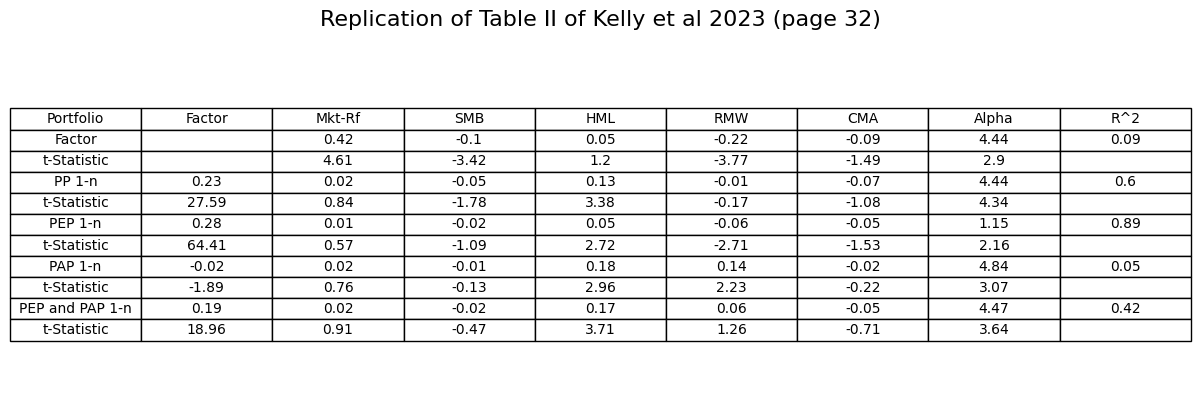

In [10]:
# Assemble regression outputs into row-wise lists for the summary table:
# Each row starts with a label, followed by factor coefficients, then the R² value.
rows = [
    ['Factor', ''] +
    [round(num, 2) for num in output_dict['25_Portfolios_5x5_SizeBM_monthly']
        ["regression_result_return_of_simple_factor"][0].tolist()]
    + [round(output_dict['25_Portfolios_5x5_SizeBM_monthly']
        ["regression_result_return_of_simple_factor"][3], 2)],
    ['t-Statistic', ''] +
    [round(num, 2) for num in output_dict['25_Portfolios_5x5_SizeBM_monthly']
        ["regression_result_return_of_simple_factor"][1].tolist()]
    + [''],

    ['PP 1-n'] +
    [round(num, 2) for num in output_dict['25_Portfolios_5x5_SizeBM_monthly']
        ["regression_result_realized_return_of_first_n_PP"][0].tolist()]
    + [round(output_dict['25_Portfolios_5x5_SizeBM_monthly']
        ["regression_result_realized_return_of_first_n_PP"][3], 2)],
    ['t-Statistic'] +
    [round(num, 2) for num in output_dict['25_Portfolios_5x5_SizeBM_monthly']
        ["regression_result_realized_return_of_first_n_PP"][1].tolist()],

    ['PEP 1-n'] +
    [round(num, 2) for num in output_dict['25_Portfolios_5x5_SizeBM_monthly']
        ["regression_result_realized_return_of_first_n_PEP"][0].tolist()]
    + [round(output_dict['25_Portfolios_5x5_SizeBM_monthly']
        ["regression_result_realized_return_of_first_n_PEP"][3], 2)],
    ['t-Statistic'] +
    [round(num, 2) for num in output_dict['25_Portfolios_5x5_SizeBM_monthly']
        ["regression_result_realized_return_of_first_n_PEP"][1].tolist()],

    ['PAP 1-n'] +
    [round(num, 2) for num in output_dict['25_Portfolios_5x5_SizeBM_monthly']
        ["regression_result_realized_return_of_first_n_PAP"][0].tolist()]
    + [round(output_dict['25_Portfolios_5x5_SizeBM_monthly']
        ["regression_result_realized_return_of_first_n_PAP"][3], 2)],
    ['t-Statistic'] +
    [round(num, 2) for num in output_dict['25_Portfolios_5x5_SizeBM_monthly']
        ["regression_result_realized_return_of_first_n_PAP"][1].tolist()],

    ['PEP and PAP 1-n'] +
    [round(num, 2) for num in output_dict['25_Portfolios_5x5_SizeBM_monthly']
        ["regression_result_PEP and PAP 1-n"][0].tolist()]
    + [round(output_dict['25_Portfolios_5x5_SizeBM_monthly']
        ["regression_result_PEP and PAP 1-n"][3], 2)],
    ['t-Statistic'] +
    [round(num, 2) for num in output_dict['25_Portfolios_5x5_SizeBM_monthly']
        ["regression_result_PEP and PAP 1-n"][1].tolist()]
]

# Reorder the intercept (alpha) and first factor columns to match Kelly et al.’s layout
rows[0][7], rows[0][2] = rows[0][2], rows[0][7]
rows[1][7], rows[1][2] = rows[1][2], rows[1][7]
for row in rows[2:]:
    row[1], row[7] = row[7], row[1]

# Define the table column headers: portfolio label, factor loadings, alpha, and R²
columns = ['Portfolio', 'Factor', 'Mkt-Rf', 'SMB', 'HML', 'RMW', 'CMA', 'Alpha', 'R^2']

# Convert the assembled rows into a pandas DataFrame for tabular display
df = pd.DataFrame(rows, columns=columns)

# Create a Matplotlib figure and axis to render the table
fig, ax = plt.subplots(figsize=(12, 4))
ax.axis('tight')  # Tight layout around the table
ax.axis('off')    # Hide axis lines

# Generate the table in the axis using DataFrame values and column labels
table = ax.table(
    cellText=df.values,
    colLabels=df.columns,
    cellLoc='center',
    loc='center'
)

# Disable automatic font sizing, then set a fixed font size and scale
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1.2, 1.2)

# Add a centered title above the table
fig.suptitle("Replication of Table II of Kelly et al 2023 (page 32)", fontsize=16)

# Use tight_layout to minimize overlap, then adjust the top margin for the title
plt.tight_layout()
fig.subplots_adjust(top=0.85)

# Display the table figure
plt.show()


Below is the replicated table

![alt text](Doc/Replicated_tables_or_figures/Table_2.jpg)


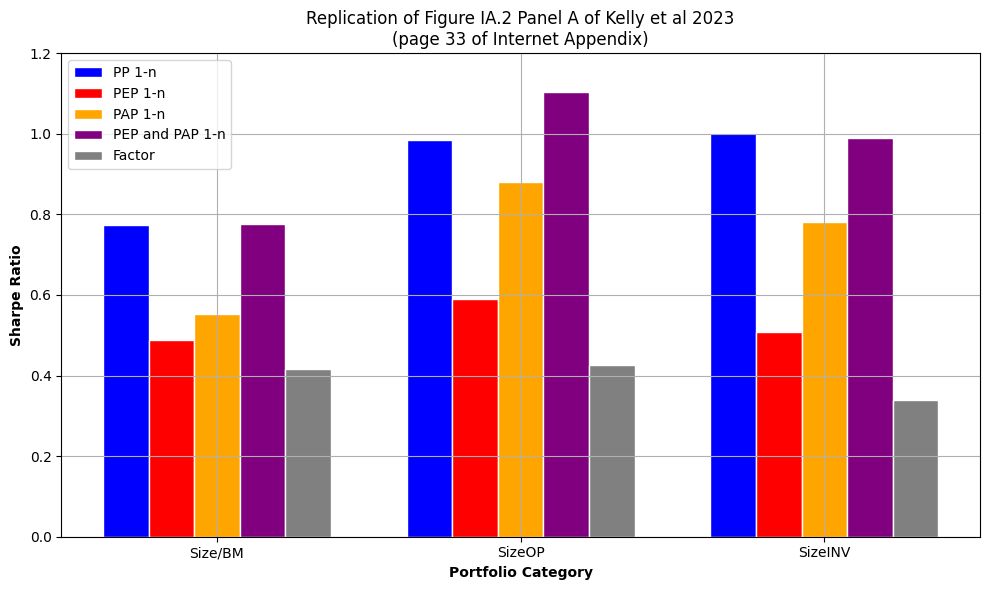

In [13]:
# Define the three portfolio categories and the width of each bar
categories = ['Size/BM', 'SizeOP', 'SizeINV']
bar_width = 0.15

# ------------------------------------------------------------
# Gather the average realized Sharpe ratios for each strategy
# for each portfolio dataset (Size/BM, SizeOP, SizeINV)
# ------------------------------------------------------------
means_pp = [
    output_dict['25_Portfolios_5x5_SizeBM_monthly']["sharpe_df"]
        .get('realized_return_of_first_n_PP'),
    output_dict['25_Portfolios_5x5_SizeOP_monthly']["sharpe_df"]
        .get('realized_return_of_first_n_PP'),
    output_dict['25_Portfolios_5x5_SizeINV_monthly']["sharpe_df"]
        .get('realized_return_of_first_n_PP')
]
means_pep = [
    output_dict['25_Portfolios_5x5_SizeBM_monthly']["sharpe_df"]
        .get('realized_return_of_first_n_PEP'),
    output_dict['25_Portfolios_5x5_SizeOP_monthly']["sharpe_df"]
        .get('realized_return_of_first_n_PEP'),
    output_dict['25_Portfolios_5x5_SizeINV_monthly']["sharpe_df"]
        .get('realized_return_of_first_n_PEP')
]
means_pap = [
    output_dict['25_Portfolios_5x5_SizeBM_monthly']["sharpe_df"]
        .get('realized_return_of_first_n_PAP'),
    output_dict['25_Portfolios_5x5_SizeOP_monthly']["sharpe_df"]
        .get('realized_return_of_first_n_PAP'),
    output_dict['25_Portfolios_5x5_SizeINV_monthly']["sharpe_df"]
        .get('realized_return_of_first_n_PAP')
]
means_pep_pap = [
    output_dict['25_Portfolios_5x5_SizeBM_monthly']["sharpe_df"]
        .get('PEP and PAP 1-n'),
    output_dict['25_Portfolios_5x5_SizeOP_monthly']["sharpe_df"]
        .get('PEP and PAP 1-n'),
    output_dict['25_Portfolios_5x5_SizeINV_monthly']["sharpe_df"]
        .get('PEP and PAP 1-n')
]
means_factor = [
    output_dict['25_Portfolios_5x5_SizeBM_monthly']["sharpe_df"]
        .get('return_of_simple_factor'),
    output_dict['25_Portfolios_5x5_SizeOP_monthly']["sharpe_df"]
        .get('return_of_simple_factor'),
    output_dict['25_Portfolios_5x5_SizeINV_monthly']["sharpe_df"]
        .get('return_of_simple_factor')
]

# ------------------------------------------------------------
# Compute x-axis positions for each strategy’s bars in the group
# ------------------------------------------------------------
r1 = np.arange(len(categories))              # PP bar positions
r2 = [x + bar_width for x in r1]             # PEP bar positions
r3 = [x + bar_width for x in r2]             # PAP bar positions
r4 = [x + bar_width for x in r3]             # Combined PEP & PAP
r5 = [x + bar_width for x in r4]             # Simple factor bars

# ------------------------------------------------------------
# Set up the figure and axis for the grouped bar chart
# ------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

# ------------------------------------------------------------
# Plot each strategy’s bars with distinct colors and labels
# ------------------------------------------------------------
ax.bar(r1, means_pp,     color='blue',   width=bar_width, edgecolor='white', label='PP 1-n')
ax.bar(r2, means_pep,    color='red',    width=bar_width, edgecolor='white', label='PEP 1-n')
ax.bar(r3, means_pap,    color='orange', width=bar_width, edgecolor='white', label='PAP 1-n')
ax.bar(r4, means_pep_pap,color='purple', width=bar_width, edgecolor='white', label='PEP and PAP 1-n')
ax.bar(r5, means_factor, color='gray',   width=bar_width, edgecolor='white', label='Factor')

# ------------------------------------------------------------
# Configure axes limits, labels, and title
# ------------------------------------------------------------
ax.set_ylim([0, 1.2])  # Set y-axis range to show ratios clearly
ax.set_xlabel('Portfolio Category', fontweight='bold')
ax.set_ylabel('Sharpe Ratio', fontweight='bold')
ax.set_title('Replication of Figure IA.2 Panel A of Kelly et al 2023\n(page 33 of Internet Appendix)')

# ------------------------------------------------------------
# Center the x-ticks under the grouped bars
# ------------------------------------------------------------
ax.set_xticks([r + 2 * bar_width for r in range(len(categories))])
ax.set_xticklabels(categories)

# ------------------------------------------------------------
# Add legend and finalize layout
# ------------------------------------------------------------
ax.legend()
plt.tight_layout()
plt.show()


Below is the replicated figure.

![alt text](Doc/Replicated_tables_or_figures/IA_2_PANEL_A.jpg)


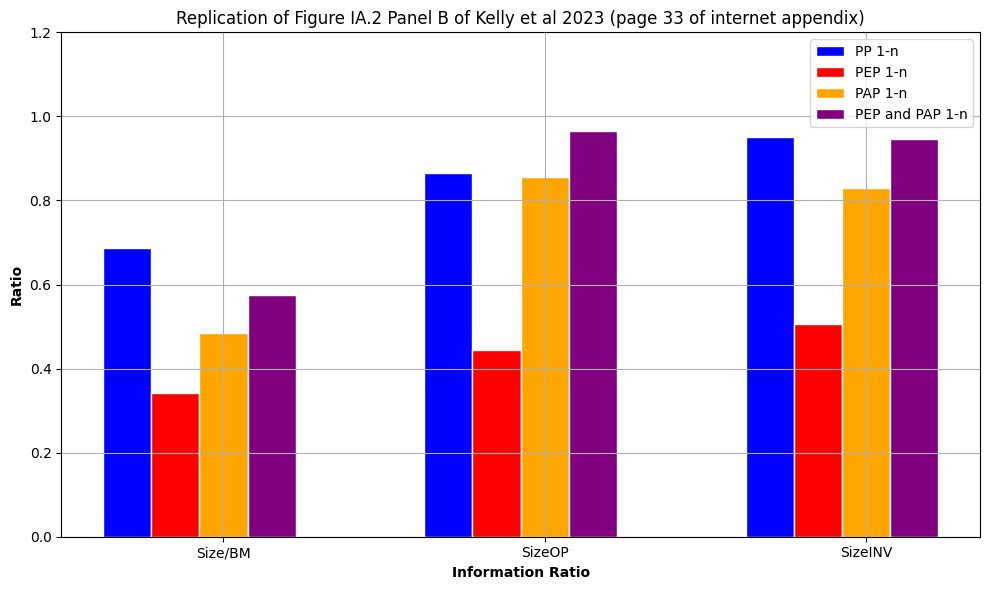

In [18]:
# Define the portfolio categories for the x-axis and set the width of each bar
categories = ['Size/BM', 'SizeOP', 'SizeINV']
bar_width = 0.15

# ------------------------------------------------------------------------------
# Extract Information Ratios (intercept IR) for each strategy and category:
#   - PP 1-n
#   - PEP 1-n
#   - PAP 1-n
#   - combined PEP & PAP 1-n
# ------------------------------------------------------------------------------
means_pp = [
    output_dict['25_Portfolios_5x5_SizeBM_monthly']["regression_result_realized_return_of_first_n_PP"][2],
    output_dict['25_Portfolios_5x5_SizeOP_monthly']["regression_result_realized_return_of_first_n_PP"][2],
    output_dict['25_Portfolios_5x5_SizeINV_monthly']["regression_result_realized_return_of_first_n_PP"][2]
]
means_pep = [
    output_dict['25_Portfolios_5x5_SizeBM_monthly']["regression_result_realized_return_of_first_n_PEP"][2],
    output_dict['25_Portfolios_5x5_SizeOP_monthly']["regression_result_realized_return_of_first_n_PEP"][2],
    output_dict['25_Portfolios_5x5_SizeINV_monthly']["regression_result_realized_return_of_first_n_PEP"][2]
]
means_pap = [
    output_dict['25_Portfolios_5x5_SizeBM_monthly']["regression_result_realized_return_of_first_n_PAP"][2],
    output_dict['25_Portfolios_5x5_SizeOP_monthly']["regression_result_realized_return_of_first_n_PAP"][2],
    output_dict['25_Portfolios_5x5_SizeINV_monthly']["regression_result_realized_return_of_first_n_PAP"][2]
]
means_pep_pap = [
    output_dict['25_Portfolios_5x5_SizeBM_monthly']["regression_result_PEP and PAP 1-n"][2],
    output_dict['25_Portfolios_5x5_SizeOP_monthly']["regression_result_PEP and PAP 1-n"][2],
    output_dict['25_Portfolios_5x5_SizeINV_monthly']["regression_result_PEP and PAP 1-n"][2]
]

# ------------------------------------------------------------------------------
# Calculate x-axis positions for each strategy’s bar group:
#   r1 = PP, r2 = PEP, r3 = PAP, r4 = combined PEP & PAP
# ------------------------------------------------------------------------------
r1 = np.arange(len(categories))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]
r4 = [x + bar_width for x in r3]

# ------------------------------------------------------------------------------
# Initialize the Matplotlib figure and axes
# ------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(10, 6))

# ------------------------------------------------------------------------------
# Plot grouped bars for each strategy without error bars
# ------------------------------------------------------------------------------
ax.bar(r1, means_pp,     color='blue',   width=bar_width, edgecolor='white', label='PP 1-n')
ax.bar(r2, means_pep,    color='red',    width=bar_width, edgecolor='white', label='PEP 1-n')
ax.bar(r3, means_pap,    color='orange', width=bar_width, edgecolor='white', label='PAP 1-n')
ax.bar(r4, means_pep_pap,color='purple', width=bar_width, edgecolor='white', label='PEP and PAP 1-n')

# ------------------------------------------------------------------------------
# Set y-axis limit to cover the expected range of Information Ratios
# ------------------------------------------------------------------------------
ax.set_ylim([0, 1.2])

# ------------------------------------------------------------------------------
# Label the axes and add a descriptive title
# ------------------------------------------------------------------------------
ax.set_xlabel('Information Ratio', fontweight='bold')
ax.set_ylabel('Ratio', fontweight='bold')
ax.set_title('Replication of Figure IA.2 Panel B of Kelly et al 2023 (page 33 of internet appendix)')

# ------------------------------------------------------------------------------
# Center the x-axis ticks under each category’s group of bars
# ------------------------------------------------------------------------------
ax.set_xticks([r + 2 * bar_width for r in range(len(categories))])
ax.set_xticklabels(categories)

# ------------------------------------------------------------------------------
# Add a legend for the strategies and display the plot
# ------------------------------------------------------------------------------
ax.legend()
plt.tight_layout()
plt.show()


Below is the replicated figure.

![alt text](Doc/Replicated_tables_or_figures/IA_2_PANEL_B.jpg)
